<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Hidden_Markov_Model_on_indiavix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
!pip install hmmlearn
!pip install yfinance

In [156]:
from hmmlearn import hmm

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
np.random.seed(1)

In [158]:
data_p = pd.read_csv('/content/NSE_INDIAVIX, 1D.csv')

In [159]:
data_p['date']=data_p.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [160]:
data_p.head(2)

,time,open,high,low,close,"NIFTY, NSE: Open","NIFTY, NSE: High","NIFTY, NSE: Low","NIFTY, NSE: Close",Volume,Volume MA,date
0,1370835900,17.35,18.629999,17.040001,18.110001,5907.8999,5931.6499,5857.3999,5878.0000,NaN,NaN,10-06-2013
1,1370922300,17.41,19.590000,17.410000,19.490000,5848.7500,5868.0498,5780.3501,5788.7998,NaN,NaN,11-06-2013


In [161]:
data_p=data_p.set_index('date')

In [162]:
data_p=data_p["10-06-2013":]

In [163]:
data_p=data_p.reset_index()

In [164]:
del data_p['time']
del data_p['Volume']
del data_p['Volume MA']

In [165]:
df=data_p.copy()

In [166]:
returns = np.log(df['close']).diff(16)

In [167]:
returns.dropna(inplace=True)

In [169]:
#returns=returns.close

In [170]:
returns.replace([np.inf, -np.inf], np.nan, inplace=True)

In [171]:
returns.dropna(inplace=True)

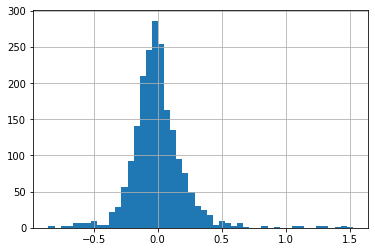

In [172]:
returns.hist(bins=50);

In [173]:
model = hmm.GaussianHMM(n_components=2, n_iter=25,covariance_type="diag")

In [174]:
X = returns.to_numpy().reshape(-1, 1)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=25, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [175]:
Z = model.predict(X)

In [176]:
Z

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

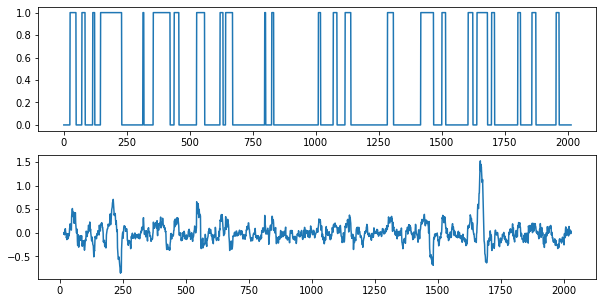

In [177]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

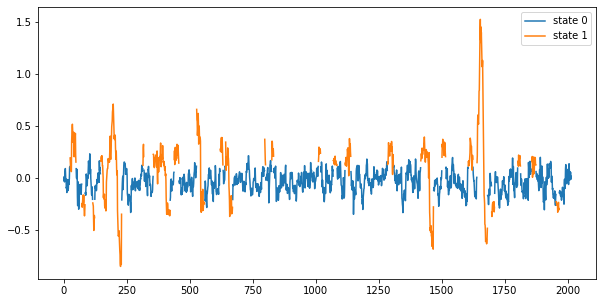

In [178]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [179]:
# transition matrix
model.transmat_

array([[0.977104  , 0.022896  ],
       [0.05585908, 0.94414092]])

In [180]:
'''
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])
'''

'\n# try to set the transition matrix intuitively\nmodel.transmat_ = np.array([\n  [0.999, 0.001],\n  [0.001, 0.999],                           \n])\n'

In [181]:
# run inference again
Z = model.predict(X)

zi= pd.concat([df.date,pd.Series(Z)],axis=1)
zi=zi.set_index('date')
zi.columns=['pred']

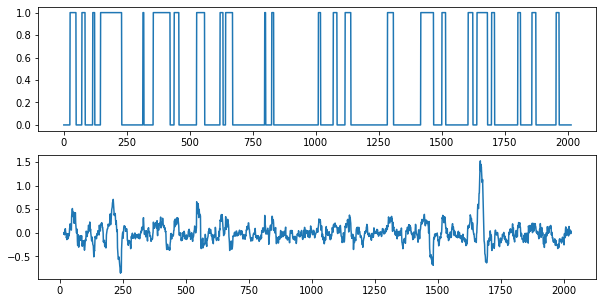

In [182]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

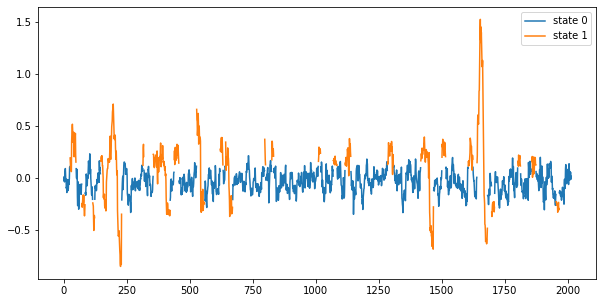

In [183]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [184]:

def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.pred.iloc[i]==1 and df.pred.iloc[i-1]==0 :
      reg1.append(i)
    elif df.pred.iloc[i]==0 and df.pred.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [185]:
sell,buy=plot_buy_sell_signal(zi)

In [186]:
#df['date'] = pd.to_datetime(df['date'])

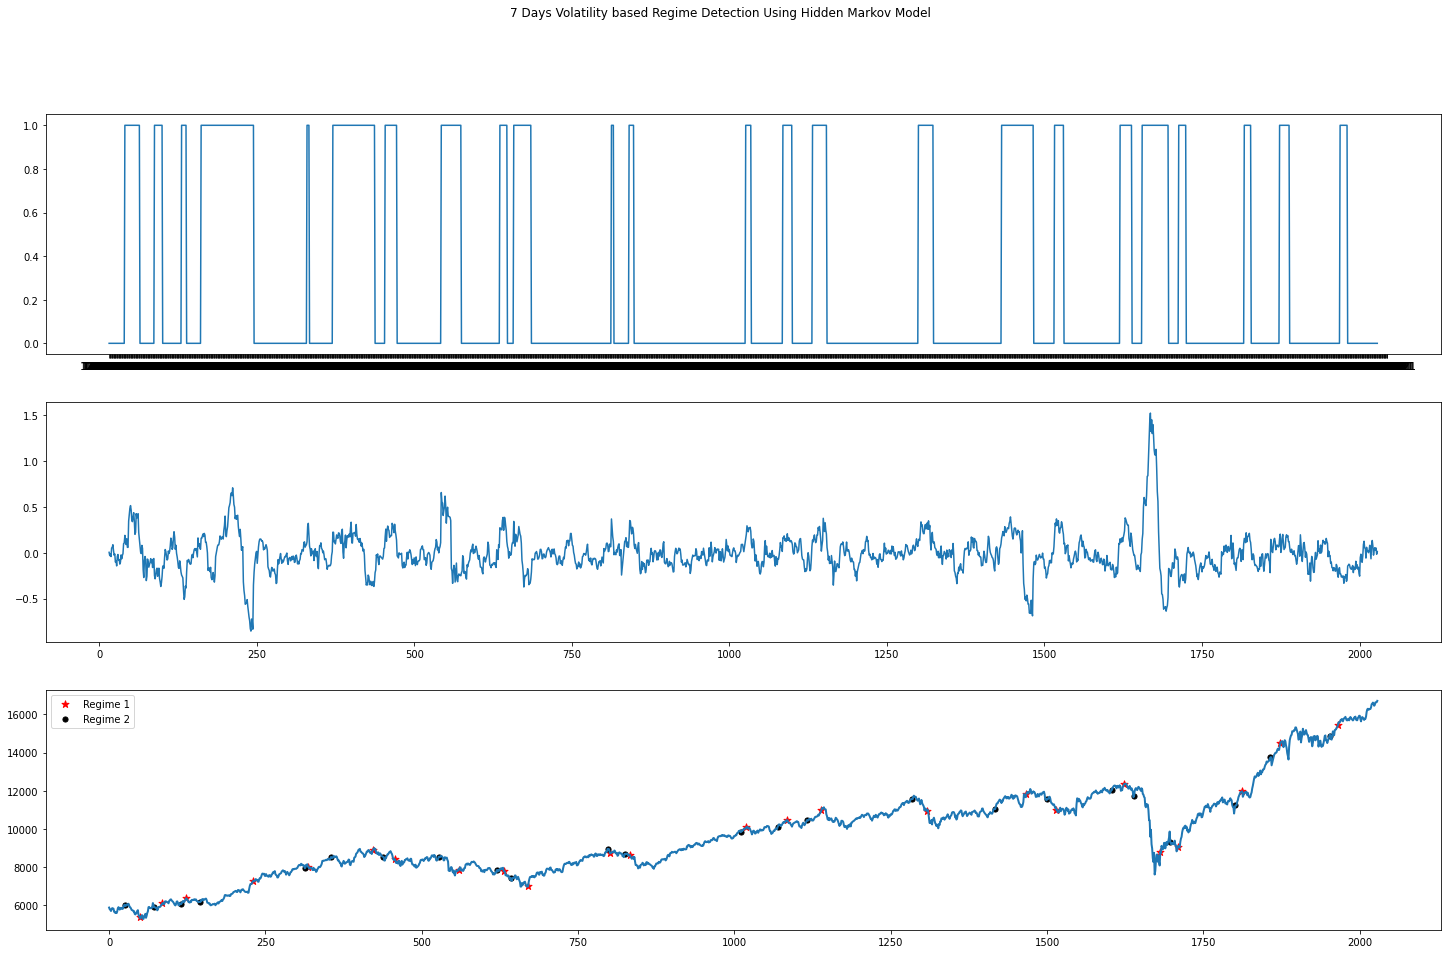

In [187]:
fig, ax = plt.subplots(figsize=(25,15),sharex=True)
plt.subplot(311)
plt.plot(zi[:])
plt.subplot(312)
plt.plot(returns[:])
plt.subplot(313)
plt.plot(df['NIFTY, NSE: Close'][:],linewidth=2)
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:]['NIFTY, NSE: Close'],marker='*',s=55,color='r',label='Regime 1')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:]['NIFTY, NSE: Close'],marker='.',s=105,color='black',label='Regime 2')
plt.legend()
plt.suptitle('7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();